# Машинное обучение, DS-поток
## Домашнее задание 2


In [1]:
%matplotlib inline

import warnings
from time import time

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


sns.set_style("dark")
sns.set(font_scale=1.4)
warnings.filterwarnings('ignore')

### Задача 2

**1.**

Реализуйте логистическую регрессию с регуляризацией для трех вариантов поиска оценки параметров:
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск, размер батча 5-10;
* IRLS.

Для измерения времени работы **каждого** шага используйте 

`from time import time`

*Замечание.* Для чистоты эксперимента время шага внутри цикла нужно замерять от конца предыдущего шага до конца текущего, а не от начала текущего шага.

In [2]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:
    
    * alpha: параметр регуляризации. 
             Если равно 0, то регуляризация не происходит.
    * lr: константа, на которую домножаем градиент при обучении
    * eps: ограничение на норму невязки в случае
           если используется критерий criterion='eps'
    * max_iter: ограничение на кол-во итераций в случае 
                если используется критерий criterion='max_iter'
    * method: если равно 'gd', то используется обычный градиентный спуск,
              если равно 'sgd', то используется стохастический 
                    градиентный спуск,
              если равно 'irls', то используется метод IRLS.
    * criterion: если равно 'eps', то используем ограничение 
                    на норму невязки,
                 если равно 'max_iter', то используем ограничение 
                    на количество итераций
    * fit_intercept: указывает, следует ли добавить константу в признаки
    * save_history: указывает, следует ли сохранять историю обучения
    '''
    

    def __init__(self, alpha=0, lr=0.5, eps=1e-3, max_iter=1e5, 
                 method='gd', criterion='max_iter', 
                 fit_intercept=True, save_history=True):
        ''' Создает модель и инициализирует параметры '''

        assert criterion in ['max_iter', 'eps'], 'выбран неправильный критерий остановки'
        assert method in ['gd', 'sgd', 'irls'], 'выбран неправильный метод'

        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
        self.criterion = criterion
        self.method = method
        self.fit_intercept = fit_intercept
        self.save_history = save_history
        self.history = []  # для хранения истории обучения

        
    @staticmethod
    def _sigmoid(x):
        ''' Cигмоида '''
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    
    def _log_likelihood(self, X, y):
        ''' Логарифм функции правдоподобия '''

        exponent = np.zeros((X.shape[0], 2))
        exponent[:, 1] = X @ self.weights
        log_sigma = -scipy.special.logsumexp(-exponent, axis=1)
        log_one_minus_sigma = -scipy.special.logsumexp(exponent, axis=1)

        return np.mean(y * log_sigma + (1 - y) * log_one_minus_sigma)

    
    def _add_intercept(self, X):
        ''' 
        Добавляем свободный коэфициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.
        '''
        
        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        X_copy[:, :-1] = X

        return X_copy


    def fit(self, X, Y):
        ''' 
        Обучает модель логистической регресии с помощью выбранного метода,
        пока не выполнится критерий остновки self.criterion.
        Также, в случае self.save_history=True, добавляет в self.history 
        текущее значение оптимизируемого функционала 
        и время обновления коэффициентов. 
        '''
        
        assert X.shape[0] == Y.shape[0]

         # добавляем свободный коэфициент
        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        # инициализируем коэфициенты
        if self.method == 'irls':
            self.weights = np.zeros(X_copy.shape[1])
        else:
            self.weights = sps.uniform(-1, 2).rvs(X_copy.shape[1])

        # произведенное число итераций
        self.n_iter_ = 0

        prev_coefs = next_coefs = self.weights

        while True:
            if self.save_history: start_time = time()  # засекаем время 
                
            prev_coefs = next_coefs

            # выбираем индексы элементов, по которым будем считать 
            # градиент на текущей итерации
            if self.method == 'sgd':
                ind = np.random.choice(np.arange(len(X_copy)), size=10)
            else:
                ind = np.arange(len(X_copy))

            # считаем градиент
            sigma = self._sigmoid(X_copy[ind] @ prev_coefs)
            grad = X_copy[ind].T @ (sigma - Y[ind]) + self.alpha * prev_coefs

            if self.method in ['sgd', 'gd']:
                # обновляем коэфициенты по методу градиентного спуска
                next_coefs = prev_coefs - self.lr * grad
            else:
                # считаем гессиан и обновляем коэфициенты по методу IRLS
                hess = X_copy.T @ np.diag(sigma * (1 - sigma)) @ X_copy +\
                        np.eye(X_copy.shape[1]) * max(self.alpha, 1e-3)
                next_coefs = prev_coefs - np.linalg.inv(hess) @ grad

            self.n_iter_ += 1

            # проверяем критерий останова
            if (self.criterion == 'max_iter') \
                and (self.n_iter_ > self.max_iter):
                break

            if (self.criterion == 'eps') and\
                (np.linalg.norm(prev_coefs - next_coefs, ord=2)
                 < self.eps):
                break

            self.weights = next_coefs

            # сохраняем историю обучения
            if self.save_history:
                end_time = time()
                self.history.append(
                    (self._log_likelihood(X_copy, Y), 
                     end_time - start_time)
                )

        if self.fit_intercept:
            self.coef_ = self.weights[:-1]  # коэффициенты модели
            self.intercept_ = self.weights[-1]  # свободный коэффициент 
        else:
            self.coef_ = self.weights
            self.intercept_ = None
        
        return self

        
    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        predicted = np.full(X.shape[0], fill_value=0)
        predicted[X_copy @ self.weights > 0] = 1

        return predicted

        
    def predict_proba(self, X):
        ''' Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1. '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        prob_predictions = np.zeros((X.shape[0], 2))
        prob_predictions[:, 1] = self._sigmoid(X_copy @ self.weights)
        prob_predictions[:, 0] = 1 - prob_predictions[:, 0]

        return prob_predictions  # shape = (n_test, 2)

Рассмотрим игрушечный датасет на 30 признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для двуклассовой классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [3]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry ',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 3 is Mean Radius, field',
 '        13 is Radius SE, field 23 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [4]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test \
        = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**2.** Теперь обучите три модели логистические регрессии без регуляризации с помощью методов
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск;
* IRLS

Постройте график, на котором нанесите три кривые обучения, каждая из которых отображает зависимость оптимизируемого функционала от номера итерации метода. Функционал должен быть одинаковый для всех моделей, то есть без минусов. Нариуйте также график зависимости этого функционала от времени работы метода.

Для чистоты эксперимента желательно не запускать в момент обучения другие задачи и провести обучение несколько раз, усреднив результаты.

*Напоминание:* все графики должны быть информативны, с подписанными осями и т.д.

Сделайте выводы. Что будет, если при обучении на очень большой по количеству элементов датасете?


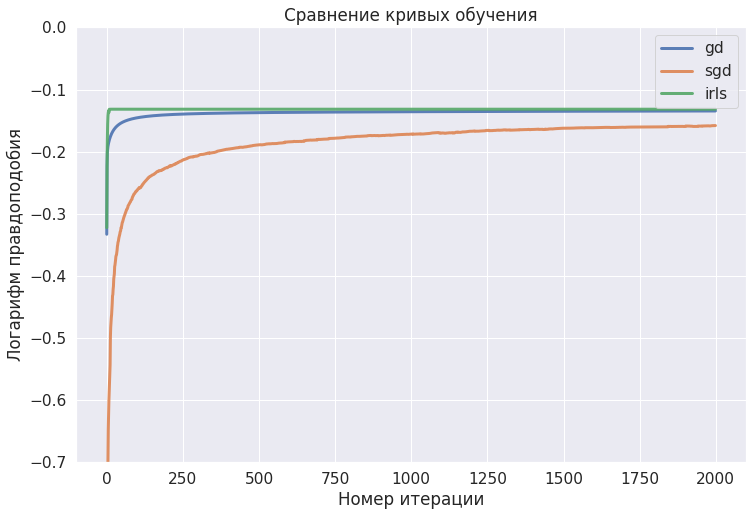

In [6]:
plt.figure(figsize=(12, 8))
plt.title('Сравнение кривых обучения')

for method in ['gd', 'sgd', 'irls']:
    clf = LogisticRegression(lr=0.01, method=method, criterion='max_iter', 
                             max_iter=2e3)
    clf.fit(X_train, Y_train)
    plt.plot(np.array(clf.history)[:, 0], label=method, lw=3, alpha=0.9)

plt.xlabel('Номер итерации')
plt.ylabel('Логарифм правдоподобия')
plt.ylim((-0.7, 0))
plt.legend()
plt.show()

Видим, что при обычном градиентном спуске функционал более гладкий, чем при стохастическом, это происходит, потому что при стохастическом градиентном спуске мы берем случайную подвыборку. По графику видно, что в каждый момент времени функционалы примерно равны. Однако, для обычного градиентного спуска мы делаем в *размер датасета* больше действий, т.к. считаем логарифм правдопообия по всему датасету. У нас это несильно заметно, так как датасет очень маленький, а в общем случае так не делают, так как зачастую это слишком дорого в виду его размера.

In [7]:
results = {}

for method in ['gd', 'sgd', 'irls']:
    time_history = []
    log_likelihood_history = []

    # производим усреднение
    for iteration in range(3):
        clf = LogisticRegression(lr=0.01, method=method, criterion='max_iter', 
                                 max_iter=2e3)
        clf.fit(X_train, Y_train)
        time_history.append(np.array(clf.history)[:, 1])
        log_likelihood_history.append(np.array(clf.history)[:, 0])

    results[method] = (np.mean(time_history, axis=0).cumsum(), 
                       np.mean(log_likelihood_history, axis=0))

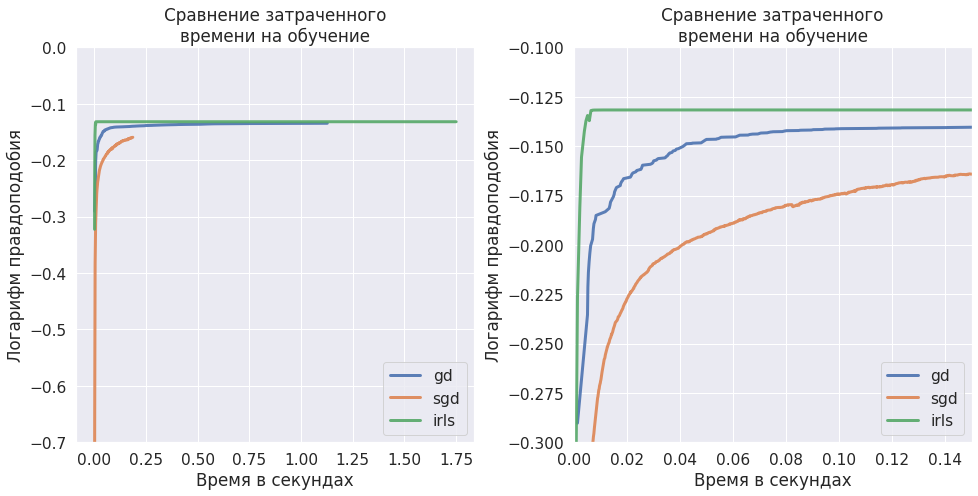

In [8]:
plt.figure(figsize=(14, 7))

for i in [1, 2]:
    plt.subplot(1, 2, i)
    plt.title('Сравнение затраченного\nвремени на обучение')

    for method in ['gd', 'sgd', 'irls']:
        plt.plot(results[method][0], results[method][1], 
                label=method, lw=3, alpha=0.9)

    plt.xlabel('Время в секундах')
    plt.ylabel('Логарифм правдоподобия')
    plt.ylim((-0.7, 0))
    if i == 2:
        plt.xlim((0, 0.15))
        plt.ylim((-0.3, -0.1))
    plt.legend()

plt.tight_layout()
plt.show()

Видим, что `sgd` требуется меньше всего времени, так как в моей реализации он считает только градиент по 10 объектам. Чуть дольше работает `gd`, так как он считает градиент уже по всей выборке. И дольше всех работает `irls`, так как в этом методе приходится обращать матрицу, что затратно по времени.

Можно заметить, что по сравнению со случаем линейной регрессии, метод IRLS сходится очень быстро.

Если у нас будет очень большой по количеству элементов датасет, то считать градиент по всей выборке будет очень дорого по времени. Таким образом, стохастический градиентный спуск лучше.

**3.** Сравните два реализованных критерия остановки по количеству проведенных итераций: евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4 и ограничение на число итераций (например, 10000). Используйте градиентный спуск.

In [9]:
clf = LogisticRegression(criterion='eps', method='sgd', eps=1e-4)
clf.fit(X_train, Y_train)

print('Потребовалось {} итераций, чтобы сойтись.'.format(clf.n_iter_))

Потребовалось 474 итераций, чтобы сойтись.


При случайной инициализации параметров потребуется всего 500 итераций, чтобы сойтись, что в 20 раз меньше, чем 10000 итераций. Следовательно, при обучении этой модели на данном датасете лучше задавать значение невязки как критерий остановки.

**4.** Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Воспользуйтесь ограничением на число итераций в качестве критерия остановки, так как для больших `learning rate` у вас может не сойтись модель. Используйте стохастический градиентный спуск. Сделайте выводы.

In [10]:
lrs = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

accuracies = []
losses = []

for lr in lrs:
    clf = LogisticRegression(lr=lr, max_iter=10000, 
                             criterion='max_iter', method='sgd')
    clf.fit(X_train, Y_train)

    accuracies.append(accuracy_score(Y_test, clf.predict(X_test)))
    losses.append(np.array(clf.history)[:, 0])

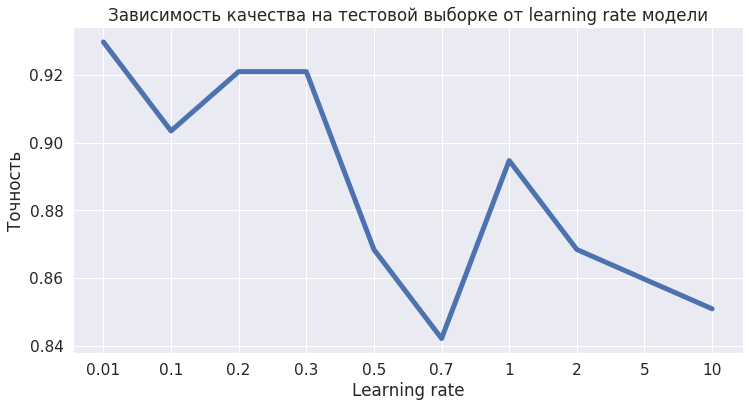

In [11]:
plt.figure(figsize=(12, 6))
plt.title('Зависимость качества на тестовой выборке от learning rate модели')
plt.plot(accuracies, lw=5)
plt.xlabel('Learning rate')
plt.ylabel('Точность')
plt.xticks(ticks=np.arange(len(lrs)), labels=lrs)
plt.show()

Постройте кривые обучения для различных `learning rate`. Не обязательно рассматривать все `learning rate` из предыдущего задания, так как их слишком много, и график будет нагроможден. Возьмите около половины из них. Какой `learning rate` лучше выбрать? Чем плохи маленькие и большие `learning rate`?

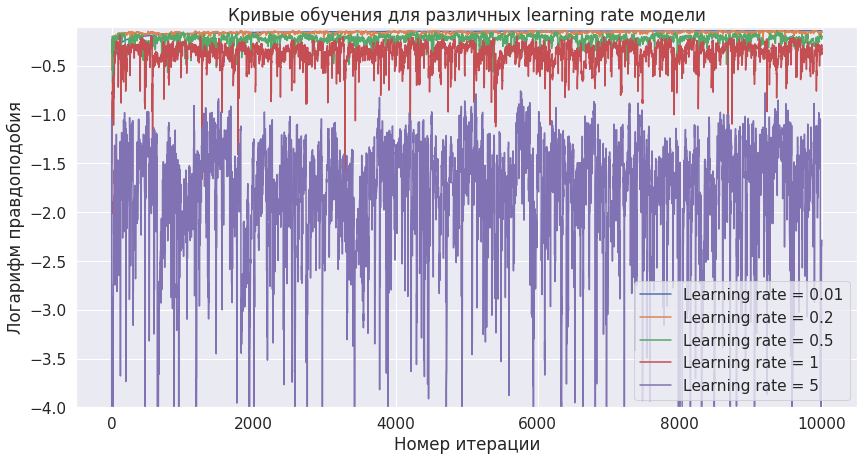

In [12]:
plt.figure(figsize=(14, 7))
plt.title('Кривые обучения для различных learning rate модели')

for loss, lr in zip(losses[::2], lrs[::2]):
    plt.plot(loss, label='Learning rate = {}'.format(lr))

plt.xlabel('Номер итерации')
plt.ylabel('Логарифм правдоподобия')
plt.ylim((-4, -0.1))
plt.legend()
plt.show()

Видим, что `learning rate` лучше брать < 1, при больших модель уже не может сойтись и это отражается на качестве на тестовой выборке. При маленьких `learning rate` модель дольше сходится. А при больших она долго осцилирует, и может не сойтись вообще. Но вообще, `learning rate` является гиперпараметром модели, и для разных моделей, для разных датасетов его нужно настраивать отдельно.

**5.** Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество, сделайте выводы. Под качеством подразумевается значение метрики, рассмотренных на семинаре.

In [13]:
iters, accuracy = [], []
coefs = np.array([0.05, 0.1, 1, 2, 5, 10])

for coef in coefs:
    clf = LogisticRegression(alpha=coef, lr=0.01, method='gd', 
                             criterion='eps', eps=1e-5)
    clf.fit(X_train, Y_train)

    iters.append(clf.n_iter_)
    accuracy.append(accuracy_score(Y_test, clf.predict(X_test)))

Построим графики:

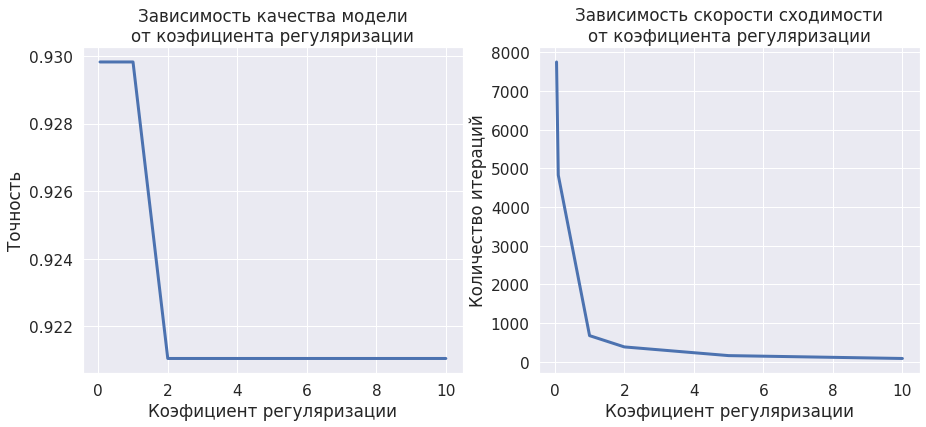

In [14]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title('Зависимость качества модели\nот коэфициента регуляризации')
plt.plot(coefs, accuracy, lw=3)
plt.xlabel('Коэфициент регуляризации')
plt.ylabel('Точность')

plt.subplot(1, 2, 2)
plt.title('Зависимость скорости сходимости\nот коэфициента регуляризации')
plt.plot(coefs, iters, lw=3)
plt.xlabel('Коэфициент регуляризации')
plt.ylabel('Количество итераций')
plt.show()

Видим, что в данном случае регуляризация не требуется. Также видим, что при большем коэфициенте регуляризации требуется меньше итераций для сходимости.

**6.** Выберите произвольные два признака, в пространстве которых визуализируйте предсказания вероятностей класса 1 для модели, которая показала наилучшее качество на предыдущем шаге.

In [15]:
clf = LogisticRegression(method='sgd', lr=0.1, max_iter=1e4)
clf.fit(X_train, Y_train)

clf.coef_

array([-4.14970211,  0.0181935 , -4.40930489, -0.9834959 ,  0.30420315,
       -2.72484124,  1.61073316, -5.40994249, -1.40044949,  3.58853558,
       -5.06000498, -0.1592104 , -0.78082189, -1.46121012, -0.45886243,
        1.18539216, -1.30596672, -0.93578841,  1.26129592, -0.16759089,
       -2.85318378, -1.65305219, -2.65212497, -0.70890115, -2.02851752,
        0.28621862, -0.77867366, -6.71469231, -1.95000826, -1.34976123])

Возьмем 10-ый признак и 28-й, так как коэфициенты перед ними имеют наибольшее значение по модулю, следовательно являются информативными. Обучим модель на этих двух признаках с `fit_intercept` = False. И визуализируем предсказания модели на обучающей и тестовой выборках.

In [16]:
clf = LogisticRegression(method='sgd', lr=0.1, 
                         max_iter=1e4, fit_intercept=False)
clf.fit(X_train[:, [9, 27]], Y_train);

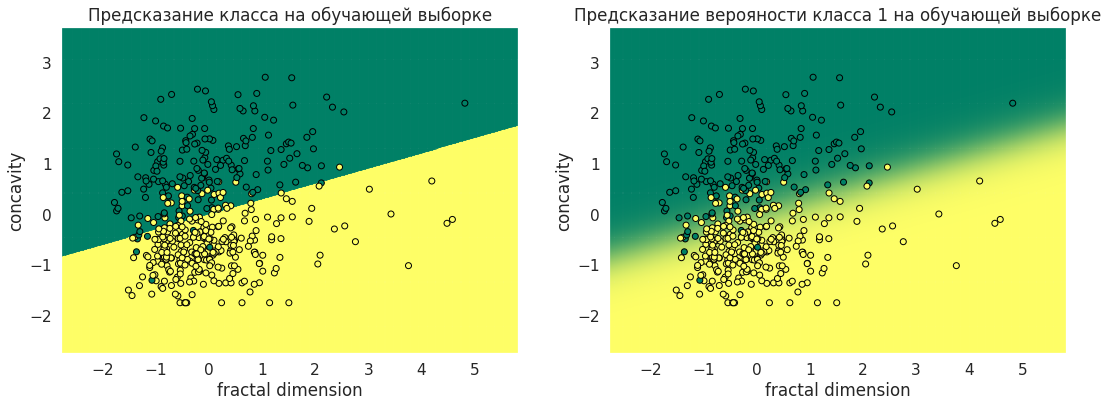

In [17]:
plt.figure(figsize=(18, 6))

x_min, x_max = X_train[:, 9].min() - 1, X_train[:, 9].max() + 1
y_min, y_max = X_train[:, 27].min() - 1, X_train[:, 27].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))

plt.subplot(1, 2, 1)
plt.title('Предсказание класса на обучающей выборке')
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_train[:, 9], X_train[:, 27], c=Y_train, 
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.subplot(1, 2, 2)
plt.title('Предсказание верояности класса 1 на обучающей выборке')
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_train[:, 9], X_train[:, 27], c=Y_train, 
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.show()

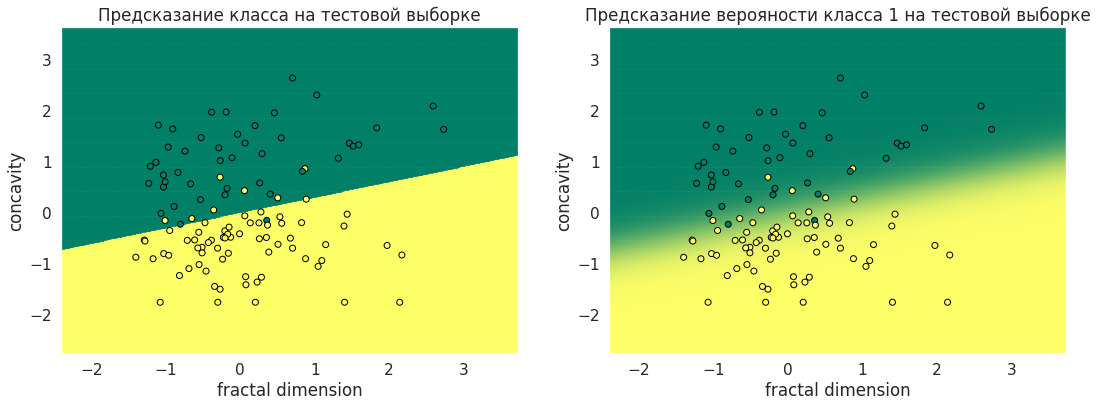

In [18]:
plt.figure(figsize=(18, 6))

x_min, x_max = X_test[:, 9].min() - 1, X_test[:, 9].max() + 1
y_min, y_max = X_test[:, 27].min() - 1, X_test[:, 27].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))

plt.subplot(1, 2, 1)
plt.title('Предсказание класса на тестовой выборке')
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_test[:, 9], X_test[:, 27], c=Y_test, 
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.subplot(1, 2, 2)
plt.title('Предсказание верояности класса 1 на тестовой выборке')
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='summer', alpha=0.5)
plt.scatter(X_test[:, 9], X_test[:, 27], c=Y_test, 
            cmap='summer', edgecolors='black')
plt.xlabel('fractal dimension'), plt.ylabel('concavity');

plt.show()

## Метрики качества в задачах классификации

Посчитаем пройденные нами метрики качества для данной задачи.

Для этого возьмем лучший классификатор из пункта 5 и обучим его:

In [19]:
clf = LogisticRegression(method='sgd', lr=0.1, 
                         max_iter=1e4, fit_intercept=False)
clf.fit(X_train, Y_train);

In [20]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

### $F_{\beta}$-мера

Посчитаем $F_{\beta}$-меру сразу для нескольких значений $\beta$ и визуализируем их на графике: 

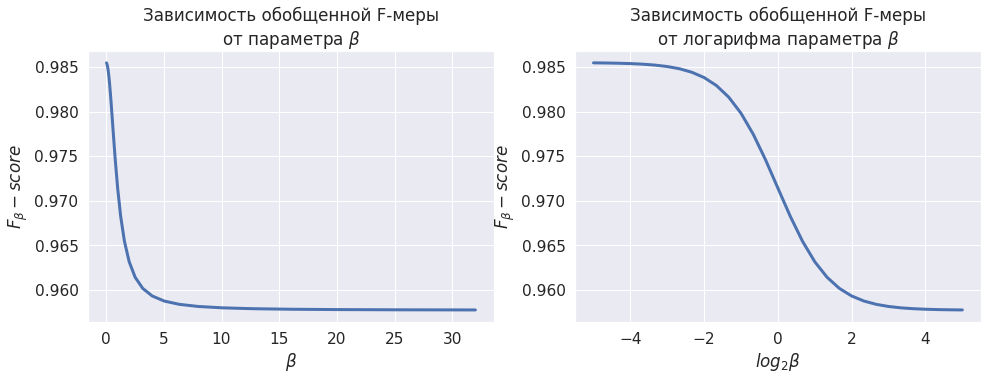

In [21]:
betas = np.power(2., np.linspace(-5, 5, 31))
fbeta_scores = [
    fbeta_score(Y_test, y_pred, beta) for beta in betas
]
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(betas, fbeta_scores, lw=3)
plt.title("Зависимость обобщенной F-меры\nот параметра $\\beta$")
plt.xlabel("$\\beta$")
plt.ylabel("$F_{\\beta}-score$")

plt.subplot(122)
plt.plot(np.log2(betas), fbeta_scores, lw=3)
plt.title("Зависимость обобщенной F-меры\nот логарифма параметра $\\beta$")
plt.xlabel("$log_2\\beta$")
plt.ylabel("$F_{\\beta}-score$")

plt.show()

### ROC-кривая и площадь под ней

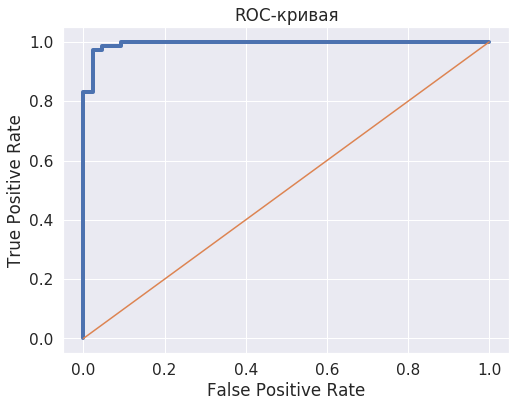

In [22]:
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
plt.plot(fpr, tpr, lw=4)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Площадь под ней:

In [23]:
roc_auc_score(Y_test, y_pred_proba)

0.9947592531935802

### PR-кривая и площадь под ней

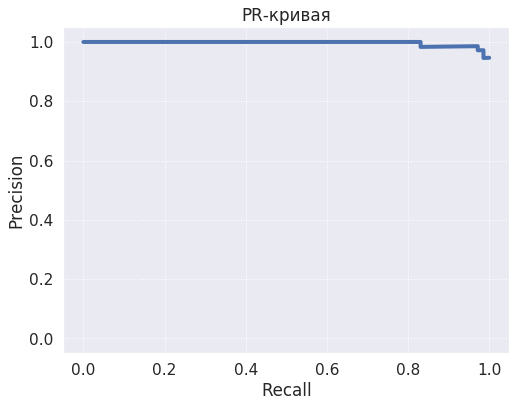

In [24]:
plt.figure(figsize=(8, 6))
precisions, recalls, thresholds = precision_recall_curve(Y_test, y_pred_proba)
plt.plot(recalls, precisions, lw=4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(ls=":")
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Площадь под ней:

In [25]:
auc(recalls, precisions) # методом трапеций

0.9966785364718078

In [26]:
average_precision_score(Y_test, y_pred_proba) # Average precision

0.996703134425388